In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import nltk
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dense, Input, LSTM, GRU, Conv1D, Dropout, Flatten, Layer, BatchNormalization
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from tensorflow import keras

from gensim.models import KeyedVectors
from gensim import models

import warnings
warnings.filterwarnings('ignore')

In [167]:
# Importing Data
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
# Number of Unique MBTI Type
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

# EDA

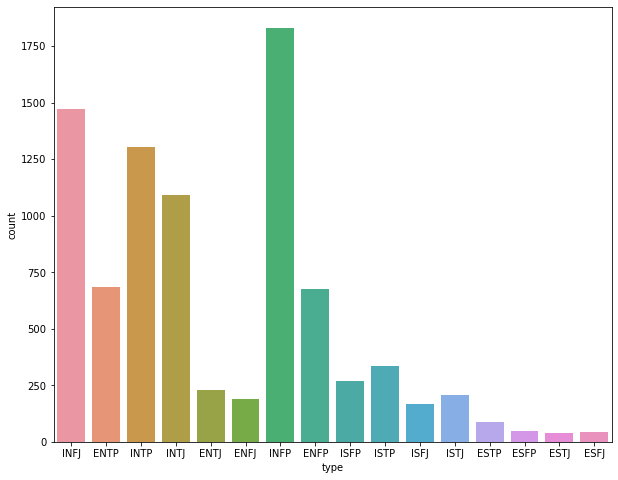

In [263]:
# Visualizing the distribution
plt.figure(figsize=(10,8))
sns.countplot(df['type'])

In [ ]:
df[df['type']]

In [269]:
E = sum(df['type'].str.contains('E'))
I = sum(df['type'].str.contains('I'))
N = sum(df['type'].str.contains('N'))
S = sum(df['type'].str.contains('S'))
T = sum(df['type'].str.contains('T'))
F = sum(df['type'].str.contains('F'))
J = sum(df['type'].str.contains('J'))
P = sum(df['type'].str.contains('P'))

In [276]:
count = pd.DataFrame(np.array([E,I,N,S,T,F,J,P]), index=['E','I','N','S','T','F','J','P'])

<BarContainer object of 8 artists>

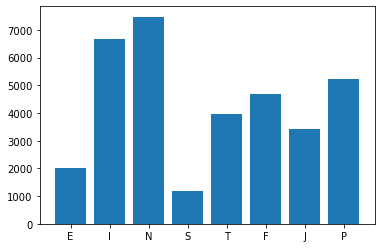

In [282]:
plt.bar(x=count.index, height = count[0].values)

In [279]:
count.index

Index(['E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'], dtype='object')

# Text Cleaning and Preprocessing

In [172]:
# Seperating Type of MBTI to Binary (E and I)
def binary_seperation(dataset, mbti_type1, mbti_type2):
    for i in range(len(df['type'])):
        if mbti_type1 in dataset['type'].iloc[i]:
            dataset['type'].iloc[i] = mbti_type1
        else:
            dataset['type'].iloc[i] = mbti_type2
    return dataset

In [11]:
ei = binary_seperation(df, 'E', 'I')

In [12]:
ei

,type,posts
0,I,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,E,'I'm finding the lack of me in these posts ver...
2,I,'Good one _____ https://www.youtube.com/wat...
3,I,"'Dear INTP, I enjoyed our conversation the o..."
4,E,'You're fired.|||That's another silly misconce...
...,...,...
8670,I,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,E,'So...if this thread already exists someplace ...
8672,I,'So many questions when i do these things. I ...
8673,I,'I am very conflicted right now when it comes ...


In [13]:
# Removing Text with website link and expanding each user's posts
# one row = one user having 50 different posts --> 1 Row with one post with corresponding MBTI Type
intravert = []
extravert = []
for i in range(len(ei)):
    if df['type'].iloc[i] == 'I':
        split = df['posts'].iloc[i].split('|||')
        for sentence in split:
            if 'http' not in sentence:
                intravert.append(sentence)
                
    else:
        split = df['posts'].iloc[i].split('|||')
        for sentence in split:
            if 'http' not in sentence:
                extravert.append(sentence)
    
I = pd.DataFrame(intravert, columns = ['Posts'])
I['type'] = 'I'

E = pd.DataFrame(extravert, columns = ['Posts'])
E['type'] = 'E'

eiei = pd.concat([I, E])

In [14]:
eiei

,Posts,type
0,What has been the most life-changing experienc...,I
1,May the PerC Experience immerse you.,I
2,Hello ENFJ7. Sorry to hear of your distress. I...,I
3,Welcome and stuff.,I
4,"Prozac, wellbrutin, at least thirty minutes of...",I
...,...,...
93085,I knit or do some other craft (as long as the ...,E
93086,[QUOTE=Kevinaswell;400994]When I say green and...,E
93087,"That's true...sort of! hahah, it goes in cycle...",E
93088,"Dear Anonymous(es), You should hire me. I'd ...",E


In [186]:
# Function that Takes in the Text (in sentence) and remove unecessary portion from the text
def text_preprocess(headlines):
    #Tokenizing Each headlines 
    token = RegexpTokenizer(r'[a-zA-Z0-9]+')

    tokenized = []
    
    #Tokenizing + Number Removal
    for i in range(len(headlines)):
        tokens = token.tokenize(headlines.iloc[i])
        num_remove = [i for i in tokens if i.isalpha()]
        tokenized.append(num_remove)
        
    #Stop words and Punctuation removal
    st = stopwords.words('english')
    punctuations = string.punctuation
    processed = []
    
    for i in range(len(tokenized)):
        words = [word for word in tokenized[i] if word.lower() not in st and word not in punctuations]
        #Num Removal
        new_text = " ".join(words)
        processed.append(new_text)
    
    #Stemming
    stemmer = PorterStemmer()
    stemmed = []
    
    for i in processed:
        stem_word = stemmer.stem(i)
        stemmed.append(stem_word)
    
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    for i in stemmed:
        lemmatize_word = lemmatizer.lemmatize(i)
        lemmatized.append(lemmatize_word)
      
    return lemmatized

In [16]:
preprocessed = text_preprocess(eiei['Posts'])
eiei['Posts'] = preprocessed
eiei.reset_index(inplace = True, drop=True)

In [19]:
#Removing the sentence with less than or equal to 2 words (this will not provide inutitive information)
drop = []
for i in range(len(eiei['Posts'])):
    if len(eiei['Posts'].iloc[i].split()) <= 2:
        drop.append(i)

eiei.drop(drop, inplace = True)

In [20]:
eiei.reset_index(inplace=True, drop=True)

In [2]:
#start here

In [187]:
ei = pd.read_csv('EI.csv')
ei.drop(columns=['Unnamed: 0'],inplace=True)

In [188]:
# Preprocessed
ei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370832 entries, 0 to 370831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Posts   370832 non-null  object
 1   type    370832 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [189]:
# Since the data has been expanded: 50 posts each row -> 1 posts each row
# Pyspark might be required to process the large amount of data, but here we will simply divide the dataset into 8 portions
I = 284212
E = 10827
testing = pd.concat([ei.iloc[:35526], ei.iloc[I:I + E]])

# Feature Extraction

### Bag of Words - Count Vectorizer

In [190]:
bow = CountVectorizer(min_df = 25, max_df = 0.8)
bow_words = bow.fit_transform(testing['Posts'])
bow_vectorized_data = pd.DataFrame(data = bow_words.toarray(), columns = bow.get_feature_names())

In [191]:
#visualizing how the vectorized sentences look like (3099 different columns/words)
bow_vectorized_data.head()

,ability,able,absolute,absolutely,abstract,absurd,abuse,accept,acceptable,accepted,...,yesterday,yet,yo,yoga,young,younger,youtube,yup,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
# Count Vectorizer counts the occurence of the word within a sentence and creates a sparse matrix
for i in bow_vectorized_data.iloc[0]:
    if i > 0:
        print(i)

1
1
1
1


### TF-IDF 

In [192]:
tfidf_vectorizer = TfidfVectorizer(min_df = 25, max_df = 0.8)
tfidf_words = tfidf_vectorizer.fit_transform(testing["Posts"])
tfidf_vectorized_data = pd.DataFrame(
    data=tfidf_words.toarray(), columns=tfidf_vectorizer.get_feature_names()
)

#min df = infrequent word ignore (if a certain word doesnt appear in more than 25 times)
#max df = frequent word ignore (if a certain word appears in more than 80% of the document -> ignore)

In [193]:
tfidf_vectorized_data.head()

,ability,able,absolute,absolutely,abstract,absurd,abuse,accept,acceptable,accepted,...,yesterday,yet,yo,yoga,young,younger,youtube,yup,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# TF-IDF provides a score to the word base on their importance 
for i in tfidf_vectorized_data.iloc[0]:
    if i > 0:
        print(i)

0.6115046370177148
0.4536504412003629
0.5388813059189429
0.36037521312604637


# Modeling

In [196]:
from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.metrics import classification_report_imbalanced 
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [201]:
# Assign Dependent and Independent Variables
X_tfidf = tfidf_vectorized_data
le = preprocessing.LabelEncoder()
y = le.fit_transform(testing['type'])

In [199]:
# Function that evaluates the model based on the confusion matrix and accuracy score
def evaluation(X, y, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    print('Accuracy Score:{}'.format(accuracy_score(y_test, y_pred)) )
    print(classification_report_imbalanced(y_test, y_pred))


# TF-IDF

In [200]:
# Logistic regression 
logistic_regression = Pipeline([('Undersample', RandomUnderSampler()), 
                                ('Logistic', LogisticRegression())])

# Support Vector Machine - L1 Regularized
svm_lasso = Pipeline([('Undersample', RandomUnderSampler()),
                    ('LinearSVC', LinearSVC(penalty='l1', dual=False))])

#Support Vector Machine - L2 Regularized
svm_ridge = Pipeline([('Undersample', RandomUnderSampler()),
                    ('LinearSVC', LinearSVC(penalty='l2', dual=False))])

# Random Forest
rf = Pipeline([('Undersample', RandomUnderSampler()),
            ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=10))])

# Naive Bayes
nb = Pipeline([('Undersample', RandomUnderSampler()),
            ('NaiveBayes', MultinomialNB())]) 

### Logistic Regrreion - TFIDF

In [202]:
evaluation(X_tfidf, y, logistic_regression)

Accuracy Score:0.5736474242816464
                   pre       rec       spe        f1       geo       iba       sup

          0       0.29      0.54      0.58      0.38      0.56      0.31      2754
          1       0.80      0.58      0.54      0.68      0.56      0.32      8835

avg / total       0.68      0.57      0.55      0.60      0.56      0.32     11589



### SVM_Lasso Regularized - TFIDF

In [203]:
evaluation(X_tfidf,y, svm_lasso)

Accuracy Score:0.5598412287514022
                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.54      0.57      0.37      0.55      0.31      2754
          1       0.80      0.57      0.54      0.66      0.55      0.31      8835

avg / total       0.68      0.56      0.55      0.59      0.55      0.31     11589



### SVM_Ridge Regularized - TFIDF

In [204]:
evaluation(X_tfidf,y, svm_ridge)

Accuracy Score:0.5529381309862801
                   pre       rec       spe        f1       geo       iba       sup

          0       0.27      0.53      0.56      0.36      0.55      0.30      2754
          1       0.79      0.56      0.53      0.66      0.55      0.30      8835

avg / total       0.67      0.55      0.54      0.59      0.55      0.30     11589



### Random Forest - TFIDf

In [205]:
evaluation(X_tfidf,y, rf)

Accuracy Score:0.6676158426093709
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.36      0.76      0.34      0.52      0.26      2754
          1       0.79      0.76      0.36      0.78      0.52      0.28      8835

avg / total       0.68      0.67      0.45      0.67      0.52      0.28     11589



### Multinomial Naive Bayes - TFIDF

In [206]:
evaluation(X_tfidf,y, nb)

Accuracy Score:0.5663128829062042
                   pre       rec       spe        f1       geo       iba       sup

          0       0.29      0.56      0.57      0.38      0.56      0.32      2754
          1       0.81      0.57      0.56      0.67      0.56      0.32      8835

avg / total       0.68      0.57      0.56      0.60      0.56      0.32     11589



### It seems like undersampling method doesnt provide enough information for class 0 (E) and therefore having very low Precision score 
<br>
 Random Forest Showed the Best performance among others

## Count Vectorized

In [207]:
# BOW vector
X_bow = bow_vectorized_data

In [208]:
evaluation(X_bow, y, logistic_regression)

Accuracy Score:0.5520752437656399
                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.55      0.55      0.37      0.55      0.30      2754
          1       0.80      0.55      0.55      0.65      0.55      0.30      8835

avg / total       0.67      0.55      0.55      0.59      0.55      0.30     11589



In [209]:
evaluation(X_bow, y, svm_lasso)

Accuracy Score:0.5452584347225817
                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.56      0.54      0.37      0.55      0.30      2754
          1       0.80      0.54      0.56      0.64      0.55      0.30      8835

avg / total       0.67      0.55      0.56      0.58      0.55      0.30     11589



In [210]:
evaluation(X_bow, y, svm_ridge)

Accuracy Score:0.5466390542756062
                   pre       rec       spe        f1       geo       iba       sup

          0       0.27      0.54      0.55      0.36      0.54      0.29      2754
          1       0.79      0.55      0.54      0.65      0.54      0.30      8835

avg / total       0.67      0.55      0.54      0.58      0.54      0.30     11589



In [211]:
evaluation(X_bow, y, rf)

Accuracy Score:0.6532056260246786
                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.38      0.74      0.34      0.53      0.27      2754
          1       0.79      0.74      0.38      0.76      0.53      0.29      8835

avg / total       0.68      0.65      0.46      0.66      0.53      0.28     11589



In [212]:
evaluation(X_bow, y, nb)

Accuracy Score:0.5651911295193718
                   pre       rec       spe        f1       geo       iba       sup

          0       0.29      0.56      0.57      0.38      0.56      0.32      2754
          1       0.81      0.57      0.56      0.67      0.56      0.32      8835

avg / total       0.68      0.57      0.56      0.60      0.56      0.32     11589



### Count Vectorize method also doesnt have a significan performance compare to TFIDF

### Oversampling Method - SMOTE

In [240]:
# Oversampling TF IDF
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X_tfidf, y)

In [241]:
lr = LogisticRegression()
evaluation(X_os, y_os, lr)

Accuracy Score:0.7306761245285144
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.71      0.75      0.73      0.73      0.53      8864
          1       0.72      0.75      0.71      0.74      0.73      0.54      8899

avg / total       0.73      0.73      0.73      0.73      0.73      0.53     17763



In [242]:
l1 = LinearSVC(penalty='l1',dual=False)
evaluation(X_os, y_os, l1)

Accuracy Score:0.729550188594269
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.72      0.74      0.73      0.73      0.53      8864
          1       0.72      0.74      0.72      0.73      0.73      0.53      8899

avg / total       0.73      0.73      0.73      0.73      0.73      0.53     17763



In [243]:
l2 = LinearSVC(penalty='l2',dual=False)
evaluation(X_os, y_os, svm_ridge)

Accuracy Score:0.7305635309350897
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.71      0.75      0.73      0.73      0.53      8864
          1       0.72      0.75      0.71      0.74      0.73      0.54      8899

avg / total       0.73      0.73      0.73      0.73      0.73      0.53     17763



In [244]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
evaluation(X_os, y_os, rf)

Accuracy Score:0.6919439283904746
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.73      0.65      0.70      0.69      0.48      8864
          1       0.71      0.65      0.73      0.68      0.69      0.47      8899

avg / total       0.69      0.69      0.69      0.69      0.69      0.48     17763



In [245]:
naive = MultinomialNB()
evaluation(X_os, y_os, naive)

Accuracy Score:0.6133536001801497
                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.60      0.62      0.61      0.61      0.38      8864
          1       0.61      0.62      0.60      0.62      0.61      0.38      8899

avg / total       0.61      0.61      0.61      0.61      0.61      0.38     17763



### Oversampling Method shows better performance for all the models and the precision score for class 0 (E) has been significantly improved
Here, Linear Classifier models (Logistic and SVM) had the best performance

## Word Embedding - Word2vec Mean

In [220]:
#Importing Pretrained Word2Vec
w2v = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz',binary=True,limit=100000)

In [222]:
# 300 Dimensional
w2v['dog'].shape

(300,)

Because Word2Vec is designed for each word within n-th dimensional space, each sentence with k-words
will have a matrix of 300 x k (Rows represents the Dimension of Word2Vec for each word) Columns represents the total number of words for a given document
<br>
Since the typical ML models doesnt take input as (m x n x l) we need to convert the multidimensional word vector into sentnence vector, one way is to average all the values within a sentence (ex. 5 word sentence having 300 dim vectors for each word -> element wise addition then element wise division)

In [223]:
# Function that averages each sentence's word vector
def w2v_mean(sentence):
    words=[]
    
    for i in sentence:
        try:
            word = w2v[i]
            words.append(word)
        # If a certain word is not presetn within a Word2Vec, replace with vector with the same dimension but 0s
        except:
            words.append(np.zeros(300,))
    mean = np.mean(words,axis=0)
    
    return mean

In [224]:
# Tokenizing each sentence - Testing purpose
t = testing['Posts'].apply(lambda x: x.split())
t.reset_index(inplace=True, drop=True)

In [226]:
# For every sentences within a dataset perform that average function
word2vec_mean = []
for i in t:
    try:
        word2vec_mean.append(w2v_mean(i))
    except:
        break

In [227]:
embedded_sentence = pd.DataFrame(word2vec_mean)
# Each sentence is in 300 Dimension (Same as Word2Vec Pretraiend model)
embedded_sentence.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.051453,0.030640,-0.048828,0.033447,0.008301,0.035919,-0.050171,-0.056030,0.053749,0.012573,...,-0.186279,0.048126,-0.127289,-0.037422,-0.081116,0.069092,0.109131,0.027954,-0.014259,0.051376
1,0.024414,-0.009064,0.002319,0.040771,-0.029541,0.036591,0.012817,-0.056183,0.034698,-0.017212,...,-0.094849,0.015869,0.008881,0.028158,0.013916,0.055420,0.060547,-0.062378,-0.003502,0.011398
2,0.065449,0.060204,0.000253,0.112965,-0.076793,-0.004001,0.056985,-0.107077,0.157815,0.089499,...,-0.031616,0.037964,-0.101028,-0.083056,-0.052663,-0.010561,0.003953,0.016550,-0.011679,-0.023034
3,-0.001700,0.026698,-0.015302,0.135875,-0.051105,-0.044892,0.036547,0.002686,0.058603,0.046406,...,-0.083194,0.057546,-0.020444,0.001233,-0.005906,-0.004411,0.033447,0.021855,-0.006804,0.041594
4,0.057475,0.042348,0.008135,0.163468,-0.086201,-0.048431,0.136312,-0.050812,0.064033,0.021683,...,-0.097992,0.051473,-0.018185,-0.013090,-0.026467,0.001295,0.057375,-0.077337,-0.000253,-0.032067


In [61]:
# oversampling
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(embedded_sentence, y)

In [58]:
evaluation(embedded_sentence, y, logistic_regression)

Accuracy Score:0.5311933730261454
                   pre       rec       spe        f1       geo       iba       sup

          0       0.27      0.55      0.53      0.36      0.54      0.29      2754
          1       0.79      0.53      0.55      0.63      0.54      0.29      8835

avg / total       0.66      0.53      0.54      0.57      0.54      0.29     11589



In [63]:
evaluation(X_os, y_os, logistic_regression)

Accuracy Score:0.5953386252322243
                   pre       rec       spe        f1       geo       iba       sup

          0       0.59      0.62      0.57      0.60      0.60      0.36      8864
          1       0.60      0.57      0.62      0.59      0.60      0.35      8899

avg / total       0.60      0.60      0.60      0.60      0.60      0.35     17763



## TFIDF - Word2Vec Hybrid

Another Novel method for transforming Word Vectors in multidimension to a sentence vector is to perform TF-IDF Word2Vec Hybrid approach.
<br>
The logic here is to multiply the TFIDF score identified for each word with the 300dim embedding vector and get the mean

In [228]:
#Extracting the TFIDF score from existing data 
def w2v_tfidf(t, i):
    tfidf_score = []
    for word in t[i]:
            if word in tfidf_vectorized_data.columns:
                score = tfidf_vectorized_data.iloc[i][word]
                tfidf_score.append(score)
            else:
                tfidf_score.append(1)
                
            
    return tfidf_score

In [229]:
# Inserting the found value into a list (For the Entire dataset)
tfidf_w2v = []
for i in range(len(t)):
    try:
        tfidf_w2v.append(w2v_tfidf(t,i))
    except:
        break

In [230]:
#Example of tfidf score for doc number 35000
tfidf_w2v[35000]

[0.23720098635613482,
 0.26584570822097026,
 0.326849302605578,
 0.4596548985978448,
 0.23369445516197762,
 0.33115997467658087,
 0.2912605569526351,
 0.3371869277762571,
 0.4383387908600179]

In [231]:
# Getting the Embedding representation of each sentence
def get_embed_vect(t,i):
    embed_vec = []
    for word in t[i]:
        try:
            embed_vec.append(w2v[i])
        except:
            embed_vec.append(np.ones(300,))
    return embed_vec

In [232]:
#The first Sentnece having 4 words in total will have 4 rows with 300 dimensions each 
np.array(get_embed_vect(t, 0)).shape

(4, 300)

In [233]:
# Retrieve Embedding vector for every sample 
embedding = []
for i in range(len(t)):
    try:
        embedding.append(get_embed_vect(t,i))
    except:
        break

In [234]:
# vector Shape
print('Embedding Vector Shape:{}'.format(np.array(embedding[2]).T.shape))
print('TFIDF Score Vector Shape{}'.format(np.array(tfidf_w2v[2]).shape))

Embedding Vector Shape:(300, 17)
TFIDF Score Vector Shape(17,)


In [235]:
# Element wise multiplication (word2vec embedded word vector * TFIDF Score of each word)
z = np.array(embedding[13]).T * np.array(tfidf_w2v[13])
#Each Word has a vector (300 Dimension - from Word2Vec) however the values are multiplied with TFIDF Score
pd.DataFrame(z, columns=[t[13]] )

,get,high,backyard,roast,eat,marshmellows,backyard,conversing,something,intellectual,followed,massages,kiss
0,0.018247,0.026826,0.084961,0.084961,0.033658,0.084961,0.084961,0.084961,0.020901,0.037860,0.039013,0.084961,0.040506
1,-0.020450,-0.030064,-0.095215,-0.095215,-0.037720,-0.095215,-0.095215,-0.095215,-0.023423,-0.042429,-0.043721,-0.095215,-0.045394
2,0.025588,0.037618,0.119141,0.119141,0.047198,0.119141,0.119141,0.119141,0.029309,0.053091,0.054708,0.119141,0.056801
3,0.024015,0.035306,0.111816,0.111816,0.044296,0.111816,0.111816,0.111816,0.027508,0.049827,0.051344,0.111816,0.053309
4,-0.023910,-0.035152,-0.111328,-0.111328,-0.044103,-0.111328,-0.111328,-0.111328,-0.027387,-0.049610,-0.051120,-0.111328,-0.053076
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.006869,0.010098,0.031982,0.031982,0.012670,0.031982,0.031982,0.031982,0.007868,0.014252,0.014686,0.031982,0.015248
296,0.013633,0.020043,0.063477,0.063477,0.025146,0.063477,0.063477,0.063477,0.015616,0.028286,0.029147,0.063477,0.030263
297,-0.023386,-0.034381,-0.108887,-0.108887,-0.043136,-0.108887,-0.108887,-0.108887,-0.026787,-0.048522,-0.049999,-0.108887,-0.051912
298,0.010487,0.015417,0.048828,0.048828,0.019343,0.048828,0.048828,0.048828,0.012012,0.021759,0.022421,0.048828,0.023279


In [236]:
# computing Element wise multiplication TFIDF * Word2Vec then take the mean to get sentence vector
def word_to_sentence(tfidf_score, w2v_vector, num_sample):
    sentence_vector = []
    for sentence in range(num_sample):
        # Embedding * tfidf score (element wise multiplication)
        z = np.array(w2v_vector[sentence]).T * np.array(tfidf_score[sentence])
        mean = np.mean(z.T, axis=0)
        sentence_vector.append(mean)
    return sentence_vector

In [238]:
hybrid = word_to_sentence(tfidf_w2v, embedding, len(testing))
hybrid = pd.DataFrame(hybrid)
hybrid

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000555,-0.000440,0.000156,0.000753,0.000543,-0.000689,-0.000015,-0.000206,-0.000283,0.000528,...,-0.000761,0.000674,-0.000030,-0.000405,0.000652,0.000570,0.000279,-0.000768,-0.000060,-0.000042
1,0.047836,0.059130,0.059795,0.042521,0.047171,-0.074079,-0.055476,-0.104973,0.014118,0.089692,...,-0.114938,-0.060459,-0.054812,0.044182,0.041690,-0.032223,-0.040029,-0.032389,0.009841,-0.042521
2,-0.004199,-0.016882,0.015925,0.022625,-0.006483,-0.022799,-0.000468,-0.025758,0.022973,0.030805,...,-0.008049,0.001327,-0.029413,0.029065,0.002828,0.000170,0.006570,0.025410,-0.012444,0.008615
3,-0.010278,-0.018485,0.054499,0.032827,-0.072028,0.020716,-0.009282,-0.058642,0.076809,0.077127,...,-0.007370,-0.010199,-0.021831,-0.013465,-0.012669,0.041751,0.013147,0.004482,0.039838,-0.096887
4,0.002761,-0.028691,0.067327,0.008846,-0.052026,0.077656,0.044184,-0.042271,0.028117,0.008177,...,-0.091427,-0.014250,-0.036724,0.071535,0.010616,0.050113,-0.009707,0.004399,0.064267,0.041888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46348,0.083499,0.077932,0.035905,0.145845,-0.011899,-0.001948,0.037296,0.100199,0.051769,-0.106322,...,-0.102425,-0.210417,-0.127475,0.084056,-0.058171,-0.194831,0.032843,-0.074592,-0.107992,0.107992
46349,-0.116711,0.248983,0.010780,0.197112,-0.095962,0.263248,0.060625,0.010293,-0.302152,0.178957,...,0.075538,0.069702,0.116711,0.328088,-0.134218,0.004985,-0.079428,0.182847,0.313823,0.057059
46350,-0.019572,-0.005799,-0.133381,0.030031,-0.235280,-0.101485,0.111012,0.083259,0.012634,0.065448,...,0.063791,-0.095686,-0.070004,-0.046186,-0.065033,0.171489,-0.021125,0.130067,0.063791,-0.140837
46351,0.070160,0.026070,0.043489,0.056945,-0.003544,-0.080732,-0.127825,-0.141281,-0.103798,0.110045,...,-0.161464,0.114370,0.010993,0.092746,0.002313,0.202791,-0.226818,-0.088901,0.015317,0.162425


### Testing witht the Model

In [246]:
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(hybrid, y)

## Logistic Regression

In [247]:
evaluation(X_os, y_os, lr)

Accuracy Score:0.7084951866238811
                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.76      0.66      0.72      0.71      0.50      8864
          1       0.73      0.66      0.76      0.69      0.71      0.49      8899

avg / total       0.71      0.71      0.71      0.71      0.71      0.50     17763



## L1- SVC

In [248]:
evaluation(X_os, y_os, l1)

Accuracy Score:0.7065810955356641
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.77      0.64      0.72      0.70      0.50      8864
          1       0.74      0.64      0.77      0.69      0.70      0.49      8899

avg / total       0.71      0.71      0.71      0.71      0.70      0.50     17763



## L2 - SVC

In [249]:
evaluation(X_os, y_os, l2)

Accuracy Score:0.7065247987389518
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.77      0.65      0.72      0.70      0.50      8864
          1       0.74      0.65      0.77      0.69      0.70      0.49      8899

avg / total       0.71      0.71      0.71      0.71      0.70      0.50     17763



## Random Forest

In [250]:
evaluation(X_os, y_os, rf)

Accuracy Score:0.756741541406294
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.76      0.75      0.76      0.76      0.57      8864
          1       0.76      0.75      0.76      0.76      0.76      0.57      8899

avg / total       0.76      0.76      0.76      0.76      0.76      0.57     17763



###  Model performance score was not improved compare to the TFIDF only model however the random forest performance showed the best score. Because we are seeing the a good score with Tree models we can try to implement Boosting algorithms to see if those improves the performance

# Neural Network - Sequential API

In [370]:
X = testing['Posts']

In [374]:
# Setting hyperparameters
max_features = 1500 #Top 1500 Vocabularies
embed_dim = 100 #Output Dimension for Embedding Layer
lstm_out = 176 #Output Dimension for LSTM Layer
batch_size =34 

In [375]:
#Tokenizing and padding with keras
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(X.values)
padded_sequence = tokenizer.texts_to_sequences(X.values)
padded_sequence = pad_sequences(padded_sequence, maxlen=30)

word_index = tokenizer.word_index

#Total Number of Vocabularies
num_tokens = len(word_index) +1

In [376]:
# Checking the shape of input and output to construct the neural layers
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(padded_sequence, testing['type'])
y_sm = pd.get_dummies(y_sm)


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size= 0.25, random_state=42)    
print("X_train:{}, Y_train:{}".format(X_train.shape, y_train.shape))
print('X_test:{}, Y_test:{}'.format(X_test.shape, y_test.shape))

X_train:(53289, 30), Y_train:(53289, 2)
X_test:(17763, 30), Y_test:(17763, 2)


## Embedding layer Implementation

Here, we are not utilizing the pretraiend embedding but instead create an embedding layer which allows the neural network to sort the words out by their own decision into a given dimension (for this case 100)

In [377]:
model = Sequential()
model.add(Embedding(input_dim = max_features, input_length = X_train.shape[1], 
                    output_dim = embed_dim, mask_zero=True))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2 ))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

print(model.summary())


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 100)           150000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 30, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 176)               195008    
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 354       
Total params: 345,362
Trainable params: 345,362
Non-trainable params: 0
_________________________________________________________________
None


In [378]:
# Running the Model
history = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, verbose =1,
         validation_data=(X_test, y_test))

Epoch 1/10
1568/1568 [==============================] - 71s 43ms/step - loss: 0.6542 - accuracy: 0.6062 - val_loss: 0.6304 - val_accuracy: 0.6383
Epoch 2/10
1568/1568 [==============================] - 75s 48ms/step - loss: 0.5979 - accuracy: 0.6714 - val_loss: 0.6083 - val_accuracy: 0.6636
Epoch 3/10
1568/1568 [==============================] - 71s 45ms/step - loss: 0.5698 - accuracy: 0.6990 - val_loss: 0.5969 - val_accuracy: 0.6745
Epoch 4/10
1568/1568 [==============================] - 67s 43ms/step - loss: 0.5516 - accuracy: 0.7131 - val_loss: 0.5960 - val_accuracy: 0.6773
Epoch 5/10
1568/1568 [==============================] - 65s 42ms/step - loss: 0.5352 - accuracy: 0.7263 - val_loss: 0.5949 - val_accuracy: 0.6826
Epoch 6/10
1568/1568 [==============================] - 66s 42ms/step - loss: 0.5208 - accuracy: 0.7362 - val_loss: 0.5978 - val_accuracy: 0.6814
Epoch 7/10
1568/1568 [==============================] - 65s 41ms/step - loss: 0.5077 - accuracy: 0.7439 - val_loss: 0.6073 -

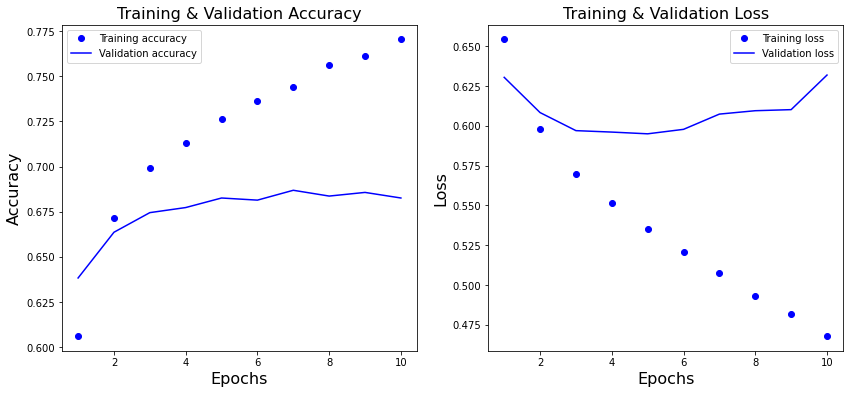

In [426]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

## Pretrained Word2Vec LSTM

In [379]:
#Creating the Emebdding Matrix to be utiliz by the neural network
embedding_dim = 300 # Embedding Dimensions
embedding_matrix = np.zeros((num_tokens, embedding_dim)) #Initializing Embedding Matrix (Weight Matrix for Embedding Layer)
embedding_vector = 0 #Initialization of vector for each word 


for word,index in word_index.items():
    try:
        embedding_vector = w2v[word]
    except:
        pass
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print('Embedding Matrix Shape:', embedding_matrix.shape)

Embedding Matrix Shape: (36354, 300)


In [372]:
# Getting the maximum token counts 
def get_max_length(df):

    max_length = 0
    for row in df['Posts']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

In [381]:
get_max_length(testing)

46

Because the input will be in sparse vector, we multiply the embedding matrix with the vector will provide a 300dimensional vector that represents each word

In [390]:
# Padding the sentnece to have equal length (46- the maximum token size)
padded_sequence = tokenizer.texts_to_sequences(X.values)
padded_sequence = pad_sequences(padded_sequence, maxlen=46)

oversample = SMOTE()
X_os, y_os = oversample.fit_resample(padded_sequence, testing['type'])
y_os = pd.get_dummies(y_os)

X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size= 0.25, random_state=42)
print("X_train:{}, Y_train:{}".format(X_train.shape, y_train.shape))
print('X_test:{}, Y_test:{}'.format(X_test.shape, y_test.shape))

X_train:(53289, 46), Y_train:(53289, 2)
X_test:(17763, 46), Y_test:(17763, 2)


In [391]:
rnn = Sequential()
rnn.add(Embedding(input_dim = num_tokens,  #Input Dimension = Total Words or Tokens 
                    output_dim = embedding_dim, #Output Dimension = Word2Vec Dimension (300 in this case)
                            input_length= X_train.shape[1], #Input Length = Pad Sequence Length
                            embeddings_initializer = #Embedding Weight Matrix = (Total Token, Word2Vec Dimension)
                            keras.initializers.Constant(embedding_matrix),
                           trainable = False))

rnn.add(SpatialDropout1D(0.5))
rnn.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(2,activation='softmax'))
rnn.compile(loss = 'categorical_crossentropy', optimizer='adam' ,metrics = ['accuracy'])
print(rnn.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 46, 300)           10906200  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 46, 300)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 150)               270600    
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 302       
Total params: 11,177,102
Trainable params: 270,902
Non-trainable params: 10,906,200
_________________________________________________________________
None


In [392]:
rnn.fit(X_train, y_train, epochs = 10, batch_size = batch_size, verbose =1,
         validation_data=(X_test, y_test))

Epoch 1/10
1568/1568 [==============================] - 179s 113ms/step - loss: 0.6815 - accuracy: 0.5582 - val_loss: 0.6600 - val_accuracy: 0.6101
Epoch 2/10
1568/1568 [==============================] - 191s 122ms/step - loss: 0.6563 - accuracy: 0.6060 - val_loss: 0.6369 - val_accuracy: 0.6396
Epoch 3/10
1568/1568 [==============================] - 187s 119ms/step - loss: 0.6334 - accuracy: 0.6382 - val_loss: 0.6161 - val_accuracy: 0.6564
Epoch 4/10
1568/1568 [==============================] - 193s 123ms/step - loss: 0.6126 - accuracy: 0.6599 - val_loss: 0.5959 - val_accuracy: 0.6737
Epoch 5/10
1568/1568 [==============================] - 199s 127ms/step - loss: 0.5970 - accuracy: 0.6755 - val_loss: 0.5868 - val_accuracy: 0.6829
Epoch 6/10
1568/1568 [==============================] - 201s 128ms/step - loss: 0.5822 - accuracy: 0.6883 - val_loss: 0.5746 - val_accuracy: 0.6961
Epoch 7/10
1568/1568 [==============================] - 194s 124ms/step - loss: 0.5689 - accuracy: 0.6995 - val_

## Multi Layered Perceptron

In [393]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, momentum = 0.9, clipnorm=0.5)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm = 0.5)

In [421]:
model = Sequential()
model.add(Dense(300, activation='relu', input_shape = (46,)))
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = sgd , metrics = ['accuracy'])
print(model.summary())

SyntaxError: invalid syntax (<ipython-input-421-c7e4683b6bef>, line 2)

In [422]:
MLP_history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose =1,
         validation_data=(X_test, y_test))

Epoch 1/5
833/833 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5201 - val_loss: 0.6916 - val_accuracy: 0.5227
Epoch 2/5
833/833 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5224 - val_loss: 0.6931 - val_accuracy: 0.5216
Epoch 3/5
833/833 [==============================] - 1s 2ms/step - loss: 0.6922 - accuracy: 0.5231 - val_loss: 0.6925 - val_accuracy: 0.5213
Epoch 4/5
833/833 [==============================] - 1s 2ms/step - loss: 0.6916 - accuracy: 0.5231 - val_loss: 0.6923 - val_accuracy: 0.5256
Epoch 5/5
833/833 [==============================] - 1s 2ms/step - loss: 0.6914 - accuracy: 0.5249 - val_loss: 0.6925 - val_accuracy: 0.5245


## LSTM - Convolution Hybrid

In [423]:
model = Sequential()
model.add(Embedding(input_dim = num_tokens,  #Input Dimension = Total Words or Tokens 
                    output_dim = embedding_dim, #Output Dimension = Word2Vec Dimension (300 in this case)
                            input_length= X_train.shape[1], #Input Length = Pad Sequence Length
                            embeddings_initializer = #Embedding Weight Matrix = (Total Token, Word2Vec Dimension)
                            keras.initializers.Constant(embedding_matrix),
                           trainable = False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 46, 300)           10906200  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 32)            28832     
_________________________________________________________________
dropout_39 (Dropout)         (None, 46, 32)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 2)               

In [424]:
rnncnn = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, verbose =1,
         validation_data=(X_test, y_test))

Epoch 1/10
1568/1568 [==============================] - 34s 21ms/step - loss: 0.6685 - accuracy: 0.5788 - val_loss: 0.6397 - val_accuracy: 0.6171
Epoch 2/10
1568/1568 [==============================] - 39s 25ms/step - loss: 0.6218 - accuracy: 0.6520 - val_loss: 0.6035 - val_accuracy: 0.6664
Epoch 3/10
1568/1568 [==============================] - 38s 24ms/step - loss: 0.5988 - accuracy: 0.6710 - val_loss: 0.5971 - val_accuracy: 0.6690
Epoch 4/10
1568/1568 [==============================] - 38s 25ms/step - loss: 0.5841 - accuracy: 0.6859 - val_loss: 0.5853 - val_accuracy: 0.6864
Epoch 5/10
1568/1568 [==============================] - 38s 24ms/step - loss: 0.5749 - accuracy: 0.6939 - val_loss: 0.5875 - val_accuracy: 0.6846
Epoch 6/10
1568/1568 [==============================] - 37s 24ms/step - loss: 0.5670 - accuracy: 0.6993 - val_loss: 0.5744 - val_accuracy: 0.6910
Epoch 7/10
1568/1568 [==============================] - 37s 23ms/step - loss: 0.5608 - accuracy: 0.7056 - val_loss: 0.5770 -

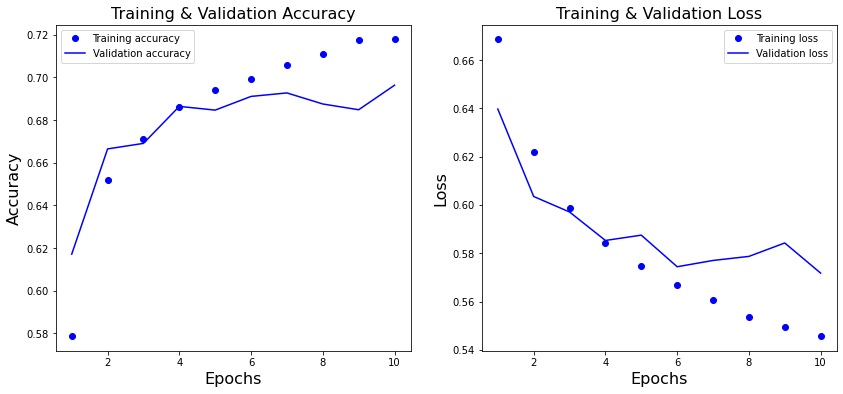

In [425]:
history_dict = rnncnn.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()